<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-CNN-Projects/blob/master/CamVid-Multiclass-Segmentation-UNet/camvid_multiclass_segmentation_unet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import cv2
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# Data Loading & Preprocessing

In [ ]:
def load_camvid_from_kaggle(base_path='/kaggle/input/camvid/CamVid', img_size=256, split='train'):
    """
    Load CamVid dataset images and masks
    """
    if split == 'train':
        img_dir = os.path.join(base_path, 'train')
        label_dir = os.path.join(base_path, 'train_labels')
    elif split == 'val':
        img_dir = os.path.join(base_path, 'val')
        label_dir = os.path.join(base_path, 'val_labels')
    elif split == 'test':
        img_dir = os.path.join(base_path, 'test')
        label_dir = os.path.join(base_path, 'test_labels')

    image_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg'))])

    images = []
    masks = []

    print(f"==> Loading {split} data ({len(image_files)} files).")

    for img_file in image_files:
        # Load Image
        img = cv2.imread(os.path.join(img_dir, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype('float32') / 255.0

        # Load Mask
        mask_file = img_file.replace('.png', '_L.png').replace('.jpg', '_L.jpg')
        mask_path = os.path.join(label_dir, mask_file)

        # Check alternative name if not found
        if not os.path.exists(mask_path):
            mask_path = os.path.join(label_dir, img_file)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img_size, img_size), interpolation=cv2.INTER_NEAREST)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

def map_labels(masks, unique_classes):
    """
    Remaps arbitrary class indices (e.g. 0, 17, 64) to sequential (0, 1, 2...)
    """
    new_masks = np.zeros_like(masks)
    for i, original_val in enumerate(unique_classes):
        new_masks[masks == original_val] = i
    return new_masks

# Metrics

In [ ]:
def dice_coefficient_multiclass(y_true, y_pred, num_classes):
    y_pred_classes = tf.argmax(y_pred, axis=-1)
    dice_scores = []
    for class_idx in range(num_classes): # Calculate for all classes including 0
        y_true_class = tf.cast(y_true == class_idx, tf.float32)
        y_pred_class = tf.cast(y_pred_classes == class_idx, tf.float32)

        intersection = tf.reduce_sum(y_true_class * y_pred_class)
        union = tf.reduce_sum(y_true_class) + tf.reduce_sum(y_pred_class)

        dice = (2.0 * intersection + 1e-7) / (union + 1e-7)
        dice_scores.append(dice)
    return tf.reduce_mean(dice_scores)

## Dice Metric

In [ ]:
class DiceMetric(keras.metrics.Metric):
    def __init__(self, num_classes, name='dice_metric', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.dice_sum = self.add_weight(name='dice_sum', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        dice = dice_coefficient_multiclass(y_true, y_pred, self.num_classes)
        self.dice_sum.assign_add(dice)
        self.count.assign_add(1.0)

    def result(self):
        return self.dice_sum / (self.count + 1e-7)

    def reset_state(self):
        self.dice_sum.assign(0.0)
        self.count.assign(0.0)

# IoU Metric

In [ ]:
class IoUMetric(keras.metrics.Metric):
    def __init__(self, num_classes, name='iou_metric', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.iou_sum = self.add_weight(name='iou_sum', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_classes = tf.argmax(y_pred, axis=-1)
        iou_scores = []
        for class_idx in range(self.num_classes):
            y_true_class = tf.cast(y_true == class_idx, tf.float32)
            y_pred_class = tf.cast(y_pred_classes == class_idx, tf.float32)

            intersection = tf.reduce_sum(y_true_class * y_pred_class)
            union = tf.reduce_sum(y_true_class) + tf.reduce_sum(y_pred_class) - intersection

            iou = (intersection + 1e-7) / (union + 1e-7)
            iou_scores.append(iou)

        mean_iou = tf.reduce_mean(iou_scores)
        self.iou_sum.assign_add(mean_iou)
        self.count.assign_add(1.0)

    def result(self):
        return self.iou_sum / (self.count + 1e-7)

    def reset_state(self):
        self.iou_sum.assign(0.0)
        self.count.assign(0.0)

# Define U-Net Model

In [ ]:
def build_unet_multiclass(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        return x

    # Encoder
    s1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D()(s1)

    s2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D()(s2)

    s3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D()(s3)

    s4 = conv_block(p3, 256)
    p4 = layers.MaxPooling2D()(s4)

    # Bottleneck
    b1 = conv_block(p4, 512)

    # Decoder
    d1 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(b1)
    d1 = layers.concatenate([d1, s4])
    d1 = conv_block(d1, 256)

    d2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(d1)
    d2 = layers.concatenate([d2, s3])
    d2 = conv_block(d2, 128)

    d3 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(d2)
    d3 = layers.concatenate([d3, s2])
    d3 = conv_block(d3, 64)

    d4 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(d3)
    d4 = layers.concatenate([d4, s1])
    d4 = conv_block(d4, 32)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(d4)

    return models.Model(inputs, outputs)


# Training Pipeline

In [ ]:
def train_and_visualize():
    base_path = '/kaggle/input/camvid/CamVid'
    img_size = 256
    epochs = 50

    # Load Data
    X_train, y_train = load_camvid_from_kaggle(base_path, img_size, 'train')
    X_val, y_val = load_camvid_from_kaggle(base_path, img_size, 'val')
    X_test, y_test = load_camvid_from_kaggle(base_path, img_size, 'test')

    if X_train is None: return

    # Validation Fallback
    if X_val is None or len(X_val) == 0:
        print("\n>>> Splitting train set to create validation...")
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Test Fallback
    if X_test is None or len(X_test) == 0:
        X_test, y_test = X_val[:10], y_val[:10]

    # Fix Labels (Remapping) -> CRITICAL STEP
    all_labels = np.concatenate([y_train, y_val, y_test])
    unique_classes = np.unique(all_labels)
    num_classes = len(unique_classes)

    print(f"\n\n>>> Remapping {num_classes} unique classes: {unique_classes} to sequential range [0, 1, 2 ...]")
    print()

    y_train = map_labels(y_train, unique_classes)
    y_val = map_labels(y_val, unique_classes)
    y_test = map_labels(y_test, unique_classes)

    # Build & Compile
    model = build_unet_multiclass((img_size, img_size, 3), num_classes)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', DiceMetric(num_classes), IoUMetric(num_classes)]
    )

    print("\n\n>>> Starting Training...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=8,
        epochs=epochs,
        callbacks=[
            keras.callbacks.EarlyStopping(
                patience=8, restore_best_weights=True, monitor='val_loss'),
            keras.callbacks.ReduceLROnPlateau(
                patience=4, factor=0.5, monitor='val_loss')
        ]
    )

    # Save Model
    model.save('unet_camvid_fixed.keras')
    print("\nModel Saved.\n")

    # Visualization (Plotting)
    plot_results(history)
    visualize_predictions(model, X_test, y_test, num_classes)

def plot_results(history):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Loss
    axes[0].plot(history.history['loss'], label='Train')
    axes[0].plot(history.history['val_loss'], label='Val')
    axes[0].set_title('Loss')
    axes[0].legend()

    # Dice
    axes[1].plot(history.history['dice_metric'], label='Train')
    axes[1].plot(history.history['val_dice_metric'], label='Val')
    axes[1].set_title('Dice Score')
    axes[1].legend()

    # IoU
    axes[2].plot(history.history['iou_metric'], label='Train')
    axes[2].plot(history.history['val_iou_metric'], label='Val')
    axes[2].set_title('IoU Score')
    axes[2].legend()

    plt.show()


def visualize_predictions(model, X, y, num_classes, num_samples=3):
    preds = model.predict(X[:num_samples])
    preds = np.argmax(preds, axis=-1)

    # Create a random color map for visualization
    colors = np.random.randint(0, 255, size=(num_classes, 3), dtype=np.uint8)

    def decode_mask(mask):
        rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for i in range(num_classes):
            rgb[mask == i] = colors[i]
        return rgb

    plt.figure(figsize=(12, 4 * num_samples))
    for i in range(num_samples):
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X[i])
        plt.title("Original")
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(decode_mask(y[i]))
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(decode_mask(preds[i]))
        plt.title("Prediction")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

==> Loading train data (369 files).
==> Loading val data (100 files).
==> Loading test data (232 files).


>>> Remapping 40 unique classes: [  0   2   7  21  26  33  38  41  44  51  56  60  64  68  71  72  77  79
  82  83  90  92  97 101 113 116 119 120 122 125 128 131 135 139 146 147
 154 161 170 184] to sequential range [0, 1, 2 ...]



I0000 00:00:1765407665.254983      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765407665.255840      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5




>>> Starting Training...
Epoch 1/50


I0000 00:00:1765407684.820706     127 service.cc:148] XLA service 0x790d7001a080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765407684.821682     127 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765407684.821704     127 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1765407686.249265     127 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1765407687.371018     127 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765407716.610650     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.4351 - dice_metric: 0.1197 - iou_metric: 0.1056 - loss: 2.6155

W0000 00:00:1765407725.351931     127 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
E0000 00:00:1765407730.345495     127 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765407730.541181     127 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.4387 - dice_metric: 0.1227 - iou_metric: 0.1085 - loss: 2.6021

W0000 00:00:1765407746.460999     127 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1765407755.667996     124 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


47/47 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.4421 - dice_metric: 0.1255 - iou_metric: 0.1113 - loss: 2.5892 - val_accuracy: 0.2563 - val_dice_metric: 0.4291 - val_iou_metric: 0.4247 - val_loss: 32.1014 - learning_rate: 0.0010
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - accuracy: 0.7263 - dice_metric: 0.4614 - iou_metric: 0.4424 - loss: 1.2866 - val_accuracy: 0.2859 - val_dice_metric: 0.4784 - val_iou_metric: 0.4745 - val_loss: 14.6823 - learning_rate: 0.0010
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - accuracy: 0.7816 - dice_metric: 0.4987 - iou_metric: 0.4773 - loss: 0.9414 - val_accuracy: 0.2789 - val_dice_metric: 0.4802 - val_iou_metric: 0.4759 - val_loss: 7.9666 - learning_rate: 0.0010
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - accuracy: 0.7751 - dice_metric: 0.5148 - iou_metric: 0.4909 - loss: 0.9026 - val_accuracy: 0.2995 - val_dice_metric: 0.4826 - val_iou_metric: 0.4772 - val_loss: 9.5213 - learning_rate: 0.0010
Epoch 5/50
47/47 ━━━━━━━━━━

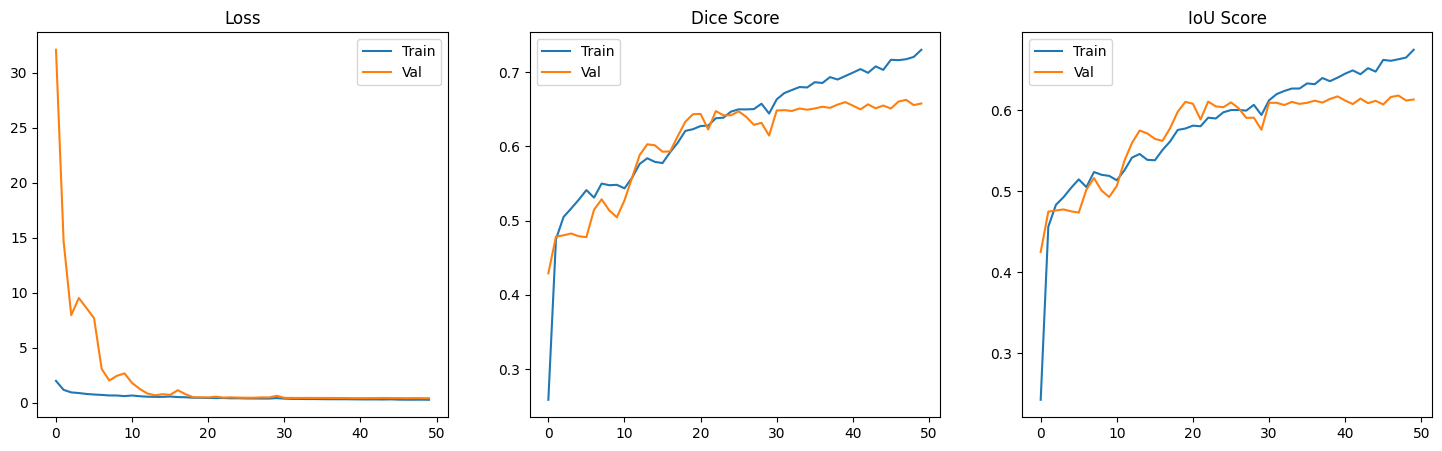

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


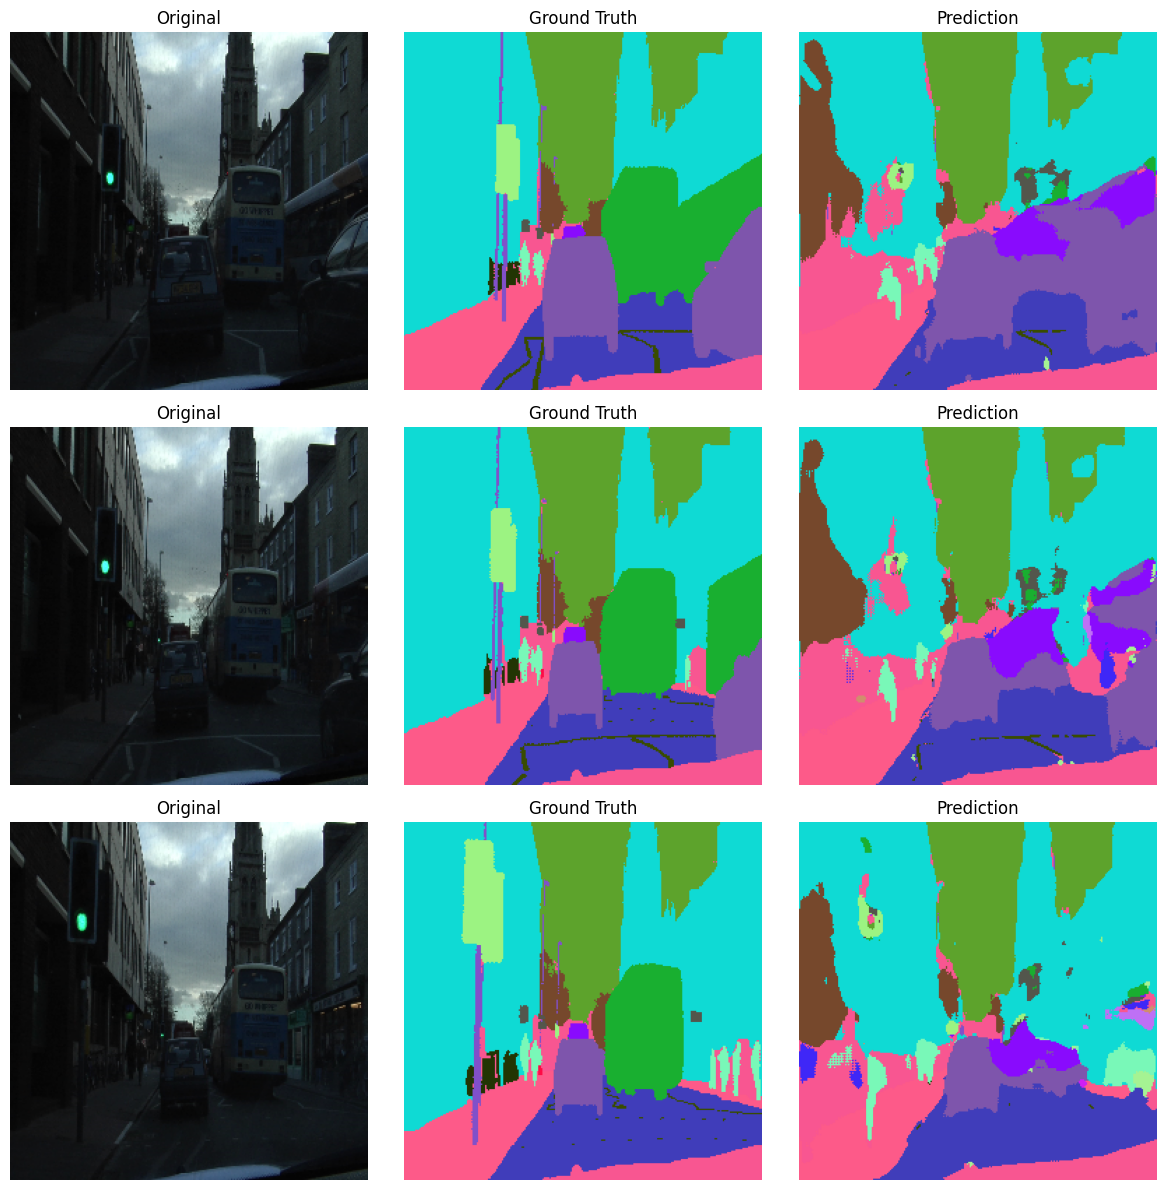

In [ ]:
if __name__ == "__main__":
    train_and_visualize()